# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
!nvidia-smi

Sat Jun 11 09:49:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0 Off |                  N/A |
| 32%   60C    P0    63W / 260W |     15MiB / 11016MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [64]:
# import libraries
import os
import numpy as np
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch.optim as optim
import torch.nn as nn

In [65]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

valid_size = 0.2
batch_size = 16

data_dir = "/home/chloe/landmark_images/"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

data_augment = transforms.Compose([transforms.Resize(224), 
                                     transforms.CenterCrop(224),
                                   transforms.RandomRotation(30),
                                     transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=data_augment)
test_data = datasets.ImageFolder(test_dir, transform=data_augment)

num_train = len(train_data)
print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

trainset = SubsetRandomSampler(train_idx)
validset = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=trainset)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=validset)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

classes = [classes_name.split(".")[1] for classes_name in train_data.classes]
print(classes)

4996
['Haleakala_National_Park', 'Mount_Rainier_National_Park', 'Ljubljana_Castle', 'Dead_Sea', 'Wroclaws_Dwarves', 'London_Olympic_Stadium', 'Niagara_Falls', 'Stonehenge', 'Grand_Canyon', 'Golden_Gate_Bridge', 'Edinburgh_Castle', 'Mount_Rushmore_National_Memorial', 'Kantanagar_Temple', 'Yellowstone_National_Park', 'Terminal_Tower', 'Central_Park', 'Eiffel_Tower', 'Changdeokgung', 'Delicate_Arch', 'Vienna_City_Hall', 'Matterhorn', 'Taj_Mahal', 'Moscow_Raceway', 'Externsteine', 'Soreq_Cave', 'Banff_National_Park', 'Pont_du_Gard', 'Seattle_Japanese_Garden', 'Sydney_Harbour_Bridge', 'Petronas_Towers', 'Brooklyn_Bridge', 'Washington_Monument', 'Hanging_Temple', 'Sydney_Opera_House', 'Great_Barrier_Reef', 'Monumento_a_la_Revolucion', 'Badlands_National_Park', 'Atomium', 'Forth_Bridge', 'Gateway_of_India', 'Stockholm_City_Hall', 'Machu_Picchu', 'Death_Valley_National_Park', 'Gullfoss_Falls', 'Trevi_Fountain', 'Temple_of_Heaven', 'Great_Wall_of_China', 'Prague_Astronomical_Clock', 'Whitby_Abb

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: My code resizes the image to 224 x 224 since most of the pretrained kernels use this size and that the features can be extracted easily with this size. I augmented the dataset with random rotations to a 30 degree so the images wont be too randomly augmented which will be hard for the model to learn.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

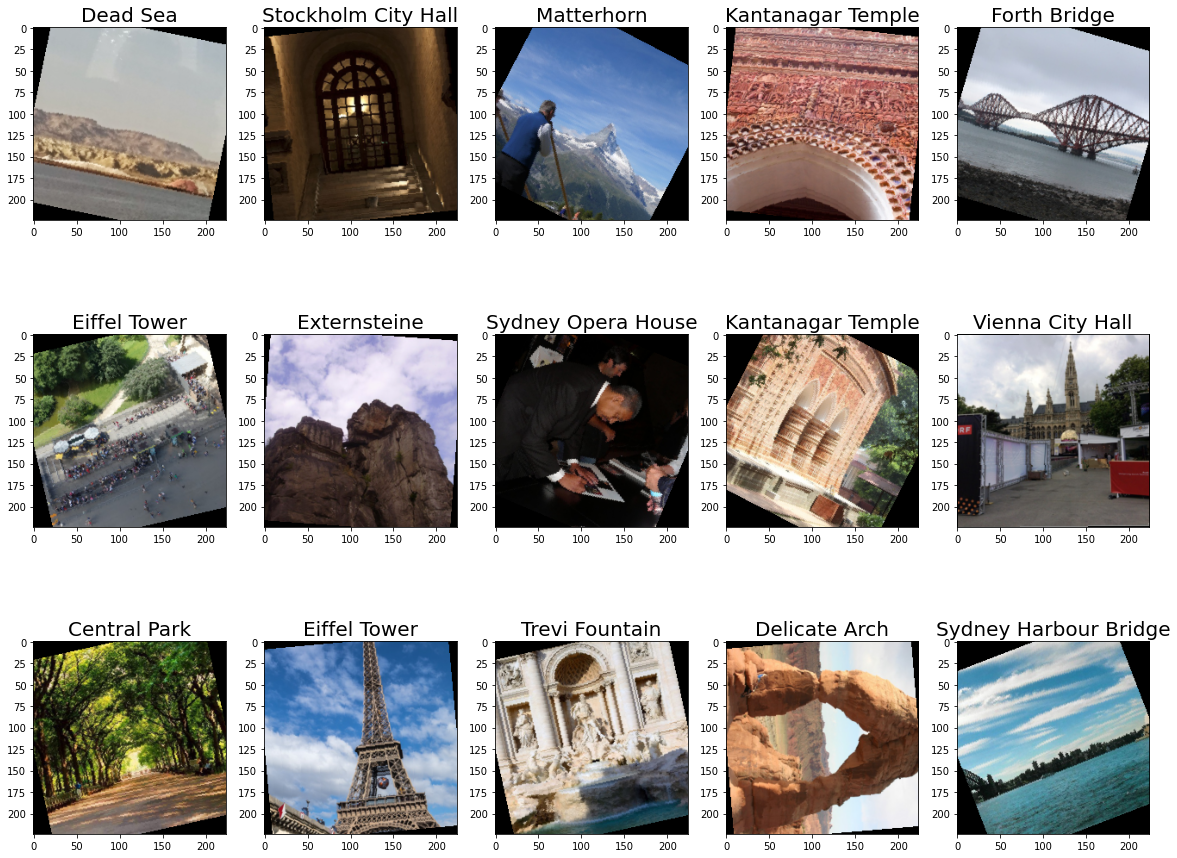

In [66]:

## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
images, labels = iter(loaders_scratch['train']).next()
classes = train_data.classes

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
num_rows = 3
num_cols = 5
frontsize = 20
figsize = (20,16)
num_images = num_rows * num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)

for ax, image, label in zip(axs.reshape(-1), images[:num_images], labels[:num_images]):
    
    # Normalize the image pixels to be between [0 - 1]
    image = (image - image.min())/ (image.max() - image.min())
    
    ax.imshow(np.transpose(image.numpy(), (1,2,0)))
    ax.set_title(str(classes[label.item()]).split('.')[1].replace('_', ' '), fontsize=frontsize)

### Initialize use_cuda variable

In [67]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda:0


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [68]:
import torch.optim as optim
import torch.nn as nn

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return torch.optim.SGD(model.parameters(), lr= 0.01)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

In [69]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size =3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size =3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size =3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*28*28 , 1024)
        self.fc2 = nn.Linear(1024, 50)

# torch.Size([16, 64, 28, 28]) 
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [70]:
from torchsummary import summary 

summary(model_scratch, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                 [-1, 1024]      51,381,248
            Linear-8                   [-1, 50]          51,250
Total params: 51,456,082
Trainable params: 51,456,082
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.41
Params size (MB): 196.29
Estimated Total Size (MB): 210.27
----------------------------------------------------------------


__Answer:__ I used 3 convolution layers with a kernel size of 3 and a padding of 1 to preserve the important features. I used a small filter size of 3 to collect local information of the images. A max pooling of factor 2 is used after each convolutional layer to focus on target features. Two fully connect linear layers are used at the end to connect to the end 50 outputs. I did not use dropout as I wanted to train with lower epochs so overfitting will not be a problem.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            model.cuda()
            output = model(data)
            loss = criterion(output, target)
            # gradient calculation
            loss.backward()
            # update weights
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
       
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [20]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # for the two Linear layers
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.zero_()

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.912018 	Validation Loss: 3.905782
Validation loss decreased
Epoch: 2 	Training Loss: 3.896231 	Validation Loss: 3.885148
Validation loss decreased
Epoch: 3 	Training Loss: 3.839594 	Validation Loss: 3.807506
Validation loss decreased
Epoch: 4 	Training Loss: 3.764216 	Validation Loss: 3.758369
Validation loss decreased
Epoch: 5 	Training Loss: 3.689000 	Validation Loss: 3.644317
Validation loss decreased
Epoch: 6 	Training Loss: 3.604980 	Validation Loss: 3.615016
Validation loss decreased
Epoch: 7 	Training Loss: 3.517501 	Validation Loss: 3.662114
Epoch: 8 	Training Loss: 3.442124 	Validation Loss: 3.501813
Validation loss decreased
Epoch: 9 	Training Loss: 3.368152 	Validation Loss: 3.465344
Validation loss decreased
Epoch: 10 	Training Loss: 3.284594 	Validation Loss: 3.420894
Validation loss decreased
Epoch: 11 	Training Loss: 3.184407 	Validation Loss: 3.394189
Validation loss decreased
Epoch: 12 	Training Loss: 3.102874 	Validation Loss: 3.304979
Valid

In [21]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 25

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.911742 	Validation Loss: 3.909460
Validation loss decreased
Epoch: 2 	Training Loss: 3.906722 	Validation Loss: 3.901967
Validation loss decreased
Epoch: 3 	Training Loss: 3.894352 	Validation Loss: 3.879923
Validation loss decreased
Epoch: 4 	Training Loss: 3.862801 	Validation Loss: 3.860840
Validation loss decreased
Epoch: 5 	Training Loss: 3.826066 	Validation Loss: 3.833473
Validation loss decreased
Epoch: 6 	Training Loss: 3.798117 	Validation Loss: 3.788617
Validation loss decreased
Epoch: 7 	Training Loss: 3.771934 	Validation Loss: 3.768124
Validation loss decreased
Epoch: 8 	Training Loss: 3.750580 	Validation Loss: 3.859782
Epoch: 9 	Training Loss: 3.728737 	Validation Loss: 3.765106
Validation loss decreased
Epoch: 10 	Training Loss: 3.703641 	Validation Loss: 3.707335
Validation loss decreased
Epoch: 11 	Training Loss: 3.671071 	Validation Loss: 3.678729
Validation loss decreased
Epoch: 12 	Training Loss: 3.638790 	Validation Loss: 3.679599
Epoch

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [71]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.144671


Test Accuracy: 23% (288/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [30]:
# import libraries
import os
import numpy as np
import torch 
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import random
import torch.optim as optim
import torch.nn as nn

In [31]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [40]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss() 


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [41]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda:0


In [44]:
## TODO: Specify model architecture
from torchvision import models
model_transfer = models.resnet50(pretrained = True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Sequential(nn.Linear(2048,256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.2),
                                 nn.Linear(256,50))

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  I used a pretrained Resnet50 for transfer learning and replaced the final fully connected layer with the corresponding input size and number of outputs. I chose resnet over vgg as it has lower complexity and a better overall accuracy. Resnet 50 also uses 3-layer bottleneck blocks to ensure improved accuracy and lesser training time. The parameters of the resnet 50 feature layers are froze to prevent backpropagation.


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [45]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
train(15, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer,
      use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.803658 	Validation Loss: 3.631403
Validation loss decreased
Epoch: 2 	Training Loss: 3.432313 	Validation Loss: 3.142266
Validation loss decreased
Epoch: 3 	Training Loss: 2.921752 	Validation Loss: 2.627920
Validation loss decreased
Epoch: 4 	Training Loss: 2.485563 	Validation Loss: 2.267633
Validation loss decreased
Epoch: 5 	Training Loss: 2.147989 	Validation Loss: 2.005347
Validation loss decreased
Epoch: 6 	Training Loss: 1.951180 	Validation Loss: 1.802364
Validation loss decreased
Epoch: 7 	Training Loss: 1.805175 	Validation Loss: 1.712411
Validation loss decreased
Epoch: 8 	Training Loss: 1.678224 	Validation Loss: 1.679156
Validation loss decreased
Epoch: 9 	Training Loss: 1.564874 	Validation Loss: 1.569429
Validation loss decreased
Epoch: 10 	Training Loss: 1.493732 	Validation Loss: 1.533364
Validation loss decreased
Epoch: 11 	Training Loss: 1.448319 	Validation Loss: 1.474830
Validation loss decreased
Epoch: 12 	Training Loss: 1.382404 	Valid

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [48]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.249966


Test Accuracy: 68% (854/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [55]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      ])
    image = transform(img)
    image_tensor = image.unsqueeze_(0)
    image_tensor = image_tensor.cuda()
    model_transfer.eval()
    output = model_transfer(image_tensor)
    value, index = output.topk(k)
    top_classes = [classes[class_id] for class_id in index[0].tolist()]
    return top_classes

# test on a sample image
predict_landmarks('/home/chloe/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Sydney_Opera_House']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

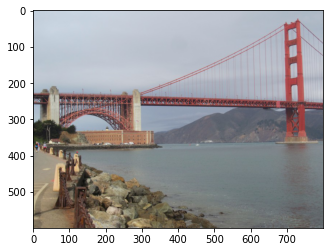

Predicted Landmarks: 
 1. Golden_Gate_Bridge 
 2. Forth_Bridge 
 3. Brooklyn_Bridge


In [60]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()

    print("Predicted Landmarks: \n 1. {} \n 2. {} \n 3. {}".format(predicted_landmarks[0], predicted_landmarks[1],predicted_landmarks[2]))
    
# test on a sample image
suggest_locations('/home/chloe/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The outputs are not as accurate as expected as it only got 1/4 correctly.

Possible points for improvement:
1. Spend more time tuning the hyperparameters. Use a different optimizer, play around with the learning rate and train with higher number of epochs.
2. Increase number of training data.
3. Try other architectures or adjust the number of fully connected layers.

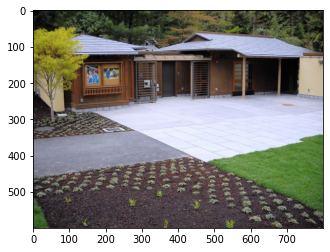

Predicted Landmarks: 
 1. Stockholm_City_Hall 
 2. Changdeokgung 
 3. Temple_of_Heaven


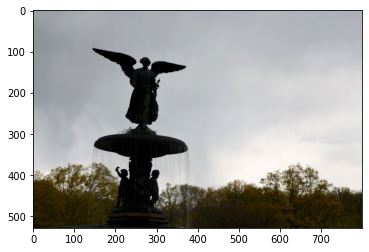

Predicted Landmarks: 
 1. Stockholm_City_Hall 
 2. Washington_Monument 
 3. Wroclaws_Dwarves


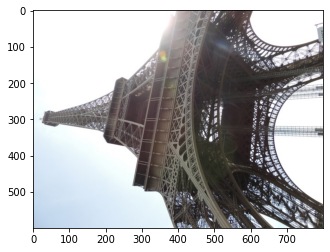

Predicted Landmarks: 
 1. Eiffel_Tower 
 2. Monumento_a_la_Revolucion 
 3. Sydney_Harbour_Bridge


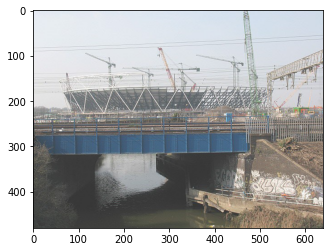

Predicted Landmarks: 
 1. Brooklyn_Bridge 
 2. Forth_Bridge 
 3. London_Olympic_Stadium


In [61]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('/home/chloe/landmark_images/test/27.Seattle_Japanese_Garden/0ce73dccfd83f5d9.jpg')
suggest_locations('/home/chloe/landmark_images/test/15.Central_Park/2c547256a34c84c7.jpg')
suggest_locations('/home/chloe/landmark_images/test/16.Eiffel_Tower/316c1a027d414a43.jpg')
suggest_locations('/home/chloe/landmark_images/test/05.London_Olympic_Stadium/2b924dbe0974d3ea.jpg')

